### Notebook to genereate plots of isentropic binned variables.

James Ruppert  
jruppert@ou.edu  
5/10/24

In [1]:
# NOTE: Using copied tracking from CTL for NCRF tests

import numpy as np
from matplotlib import rc
from matplotlib import colors, ticker
import matplotlib.pyplot as plt
from read_functions import *
from thermo_functions import *

### Main settings

In [2]:
storm = 'haiyan'
storm = 'maria'

# Set to true to do sensitivty test comparisons
# Else: analysis of CTL only
do_tests=True
# do_tests=False
t1_test=12 # n time steps to sample for tests

# Set to true to use vertical hi-res data
do_hires=True
# do_hires=False

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'

# pclass_names = ['all','noncloud','shallowc','congest','deepc','strat','anvil']
# pclass_title=["All", "Non-cloud", "Shallow", "Cong", "Deep", "Strat", "Anvil"]
pclass_names = ['all','shallowc','congest','deepc','strat','anvil']
pclass_title=["All", "Shallow", "Cong", "Deep", "Strat", "Anvil"]
# pclass_names = ['all','mcs','congest','deepc','strat','anvil']
# pclass_title=["All", "MCS", "Cong", "Deep", "Strat", "Anvil"]
npclass = len(pclass_names)

# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','ncrf36h','STRATANVIL_ON','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','NCRF','STRATANVON','STRATANVOFF','STRATOFF']
    # tests = ['ctl','ncrf36h']
    # tests_str = ['CTL','NCRF']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
    tests_str = ['CTL','NCRF']

if not do_tests:
    tests = [tests[0]]
    tests_str = [tests_str[0]]

time_neglect=12 # time steps from start to neglect

# Shift starting-read time step for CRFON comparison
t0_test=0
# if 'crfon' in tests[1]:
#     t0_test=24 # CRFON is restarted at t=24 in NCRF
    # memb0=5 # for CRFFON test

# Members
nmem = 10 # number of ensemble members
enstag = str(nmem)

### Read functions

In [3]:
# Theta-e (equivalent potential temperature) bins
fmin=305; fmax=365 # K
nbins = 70
bins=np.linspace(fmin,fmax,num=nbins)

# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
nt=nt_data-time_neglect
if do_hires:
    pres = np.arange(1000,25,-25)

In [4]:
################################################
#### NetCDF variable metadata

def var_regrid_metadata(nt,nz,nbins):

    nbinsm1 = nbins-1

    var_names = [
        'bins',
        'pres',
        'theta_e_mn',
        'frequency',
        'tmpk',
        'qv',
        'rho',
        # 'h_diabatic',
        'lw',
        'lwc',
        'sw',
        'swc',
        'w',
    ]
    descriptions = [
        'equivalent potential temperature bins',
        'pressure',
        'mean equivalent potential temperature',
        'frequency',
        'temperature',
        'water vapor mixing ratio',
        'density',
        # 'H_DIABATIC',
        'LW heat tendency',
        'LW clear-sky heat tendency',
        'SW heat tendency',
        'SW clear-sky heat tendency',
        'vertical motion',
    ]
    units = [
        'K',
        'hPa',
        'K',
        'n-cells',
        'K',
        'kg/kg',
        'kg/m^3',
        # 'K/s',
        'K/s',
        'K/s',
        'K/s',
        'K/s',
        'm/s',
    ]
    dims_all = (nt,nz,nbinsm1)
    dim_names = ('nt','nz','nbinsm1')
    dims_set = [
        [('nbins',),(nbins,)],
        [('nz',),(nz,)],
        [('nt','nz'),(nt,nz)],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        [dim_names,dims_all],
        # [dim_names,dims_all],
    ]

    len1=len(var_names); len2=len(descriptions); len3=len(units); len4=len(dims_set) #len4=len(dim_names)
    if (len1 != len2) or (len1 != len3) or (len1 != len4):
        raise ValueError("Variable info counts are off")

    return var_names, descriptions, units, dims_set

# Variable info
var_names, descriptions, units, dims_set = var_regrid_metadata(nt,nz,nbins)

In [5]:
# Main read loops for 3D (dependent) variables

if do_hires:
    file_tag = '_HiRes.nc'
else:
    file_tag = '.nc'

ntest=len(tests)

allvars = []
# (itest, imemb, ivariable(ndarray))

for itest in range(ntest):

    test_str=tests[itest]
    print('Running test: ',test_str)

    if test_str == 'ctl':
        t0=time_neglect
        t1=nt+t0
        if do_tests:
            t0=36
            # t1=t0+49
            # Control test time sample
            t1=t0+t1_test
    else:
        t0=0
        t1=49
        # Control test time sample
        t1=t1_test

    # Loop over ensemble members

    itest_ens = []
    for imemb in range(nmem):

        print('Running member: ',memb_all[imemb])
        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_str+'/'+datdir2

        imemb_allclass = []
        for ipclass in range(npclass):

            pclass_tag = pclass_names[ipclass]
            isentrop_file = datdir+'binned_isentrop_'+pclass_tag+file_tag
            ncfile = Dataset(isentrop_file)

            vars_ipclass = []
            for ivar in var_names:
                vars_ipclass.append(ncfile.variables[ivar][t0:t1,...])

            ncfile.close()
            
            imemb_allclass.append(vars_ipclass)

        itest_ens.append(imemb_allclass)

    allvars.append(itest_ens)

Running test:  ctl
Running member:  memb_01
Running member:  memb_02
Running member:  memb_03


Running member:  memb_04
Running member:  memb_05
Running member:  memb_06
Running member:  memb_07
Running member:  memb_08
Running member:  memb_09
Running member:  memb_10
Running test:  ncrf48h
Running member:  memb_01
Running member:  memb_02
Running member:  memb_03
Running member:  memb_04
Running member:  memb_05
Running member:  memb_06
Running member:  memb_07
Running member:  memb_08
Running member:  memb_09
Running member:  memb_10


### Plot functions

In [6]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

rc('font', **font)

#### Main plot code

In [7]:
def plot_pclass_multipan(bins, pres, invar, th_mean, title_tag, units, pclass_title,
                    cmap='RdGy_r', norm=None, th_mean0=None, do_thm0_pclass=False):

        fig, axs = plt.subplots(2,3, figsize=(14,9)) # row, column

        fig_title = title_tag#+' ('+test_str.upper()+')  '
        fig.suptitle(fig_title)

        axs[1,1].set_xlabel(r'$\theta_e$ [K]')
        for irow in range(2):
                axs[irow,0].set_ylabel('Pressure [hPa]')

        # for ipclass in range(npclass):
        for ipclass in range(npclass):
                # if ipclass == 1:
                #         continue
                icol=ipclass
                if icol < 3:
                        irow=0
                else:
                        irow=1
                        icol-=3
                subtitle = pclass_title[ipclass]
                axs[irow,icol].set_title(subtitle)
                axs[irow,icol].set_yscale('log')
                nz=pres.size
                dp = pres[0]-pres[1]
                p2 = np.append(np.array(pres+dp/2), pres[nz-1]-dp/2)
                pltvar = invar[ipclass]
                im = axs[irow,icol].pcolormesh(bins, p2, pltvar, cmap=cmap, norm=norm)
                axs[irow,icol].set_xlim(305, 365)
                axs[irow,icol].set_ylim(1000, 100)
                axs[irow,icol].yaxis.set_major_formatter(ticker.ScalarFormatter())
                axs[irow,icol].yaxis.set_minor_formatter(ticker.ScalarFormatter())
                axs[irow,icol].grid(True, axis='x', color='0.55', linewidth=0.5)
                axs[irow,icol].grid(True, axis='y', color='0.55', linewidth=0.5, which='both')
                # Remove labels for inner panels
                if icol > 0:
                        yticks = np.arange(1000,0,-100)
                        axs[irow,icol].yaxis.set_ticks(yticks, labels=np.repeat('',yticks.size))
                if irow == 0:
                        xticks = axs[irow,icol].get_xticks()
                        axs[irow,icol].xaxis.set_ticks(xticks, labels=np.repeat('',xticks.size))
                # Mean profiles
                linecol='g'
                axs[irow,icol].plot(th_mean[ipclass], pres, "-"+linecol)
                if do_thm0_pclass:
                        axs[irow,icol].plot(th_mean0[ipclass], pres, "--"+linecol)
                else:
                        axs[irow,icol].plot(th_mean[0], pres, "--"+linecol)

        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.83, 0.25, 0.02, 0.5]) # L, B, Width, Height
        fig.colorbar(im, cax=cbar_ax, label=units)

        # plt.tight_layout()
        plt.show()
        plt.close()

In [8]:
# Individual panels
# def plot_binned_var(bins, pres, binvar, th_mean, title_tag, units, pclass_title, test_str,
#                     cmap='RdGy_r', norm=None):
#         for ipclass in range(npclass):
#                 fig_title = title_tag+' ('+pclass_title[ipclass]+'; '+test_str.upper()+')'
#                 # create figure
#                 fig = plt.figure()#figsize=(14,4))
#                 ax = fig.add_subplot(111)
#                 ax.set_title(fig_title)
#                 ax.set_xlabel(r'$\theta_e$ [K]')
#                 ax.set_ylabel('Pressure [hPa]')
#                 ax.set_yscale('log')
#                 nz=pres.size
#                 dp = pres[0]-pres[1]
#                 p2 = np.append(np.array(pres+dp/2), pres[nz-1]-dp/2)
#                 ibinvar = binvar[ipclass]
#                 im = ax.pcolormesh(bins, p2, ibinvar, cmap=cmap, norm=norm)
#                 # Mean profile
#                 plt.plot(th_mean[ipclass], pres, "-k")
#                 plt.plot(th_mean[0], pres, "--k")
#                 plt.xlim(300, 370)
#                 plt.ylim(1000, 100)
#                 ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
#                 ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
#                 cbar = plt.colorbar(im, ax=ax, shrink=0.75)
#                 cbar.ax.set_ylabel(units)
#                 # plt.savefig(figdir+'pclass_frac_'+binvartag+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 #             bbox_inches='tight', pad_inches=0.2)
#                 plt.show()
#                 plt.close()

#### Variable grab function

In [9]:
def get_var(allvars_ktest, str_name):
    str_ind = var_names.index(str_name)
    dims = [nmem,npclass]
    dims_var = np.shape(allvars_ktest[0][0][str_ind])
    for iappend in dims_var:
        dims.append(iappend)
    var_np = np.ndarray(dims, np.float64)
    for imemb in range(nmem):
        for ipclass in range(npclass):
            var_np[imemb,ipclass,...] = allvars_ktest[imemb][ipclass][str_ind]
    return var_np

#### CTL plots

In [10]:
def run_ctl_plots(do_freq=False, do_freqnorm=False, do_relhum=False, do_vmf=False, do_lwcrf=False,
                  do_swcrf=False, do_swrad=False, do_totrad=False):

    ktest=0

    str_name='theta_e_mn'
    th_mean = get_var(allvars[ktest], str_name)
    str_name='frequency'
    frequency = get_var(allvars[ktest], str_name)

    frequency = np.mean(frequency,axis=(0,2))
    th_mean = np.mean(th_mean,axis=(0,2))

    if do_freq:

        title_tag = 'Frequency ('+test_str.upper()+')  '
        units = ' '
        cmap = 'twilight'
        normmin=1
        normmax=1e5
        norm=colors.LogNorm(vmin=normmin, vmax=normmax)
        plot_pclass_multipan(bins, pres, frequency, th_mean, title_tag, units, pclass_title,
                             cmap=cmap, norm=norm)

    if do_freqnorm:

        title_tag = "Normalized Frequency Difference from 'All' ("+test_str.upper()+")  "
        units = 'Frequency [%]'
        cmap = 'RdGy_r'
        norm=colors.SymLogNorm(linthresh=0.01, linscale=1, vmin=-1e-1, vmax=1e-1)

        ifreq1 = frequency[0]
        freq_norm = np.copy(frequency)
        total1 = np.nansum(ifreq1)
        for ipclass in range(npclass):
            ifreq2 = frequency[ipclass]
            total2 = np.nansum(ifreq2)
            freq_norm[ipclass] = 1e2*((ifreq2/total2) - (ifreq1/total1))# / (ifreq1/total1)

        plot_pclass_multipan(bins, pres, freq_norm, th_mean, title_tag, units, pclass_title,
                             cmap=cmap, norm=norm)

    if do_relhum:

        str_name='qv'
        qv = get_var(allvars[ktest], str_name)
        str_name='tmpk'
        tmpk = get_var(allvars[ktest], str_name)

        qv_mean = np.mean(qv,axis=(0,2))
        tmpk_mean = np.mean(tmpk,axis=(0,2))
        relh = calc_relh(qv_mean, pres[np.newaxis,:,np.newaxis]*1e2, tmpk_mean, ice=True)

        title_tag = 'Relative Humidity ('+test_str.upper()+')  '
        units = '[%]'
        cmap = 'BrBG'
        norm=None

        plot_pclass_multipan(bins, pres, relh, th_mean, title_tag, units, pclass_title,
                             cmap=cmap, norm=norm)

    if do_vmf:

        str_name='w'
        w = get_var(allvars[ktest], str_name)
        str_name='rho'
        rho = get_var(allvars[ktest], str_name)
        vmf = w*rho # kg/m2/s
        vmf_mean = np.mean(vmf,axis=(0,2))

        title_tag = 'VMF ('+test_str.upper()+')  '
        units = '[kg/m$^2$/s]'
        cmap = 'RdGy_r'
        normmin=-1e0; normmax=1e0
        norm = colors.SymLogNorm(linthresh=1e-2, linscale=1, vmin=normmin, vmax=normmax)
        plot_pclass_multipan(bins, pres, vmf_mean, th_mean, title_tag, units, pclass_title,
                             cmap=cmap, norm=norm)

    if do_lwcrf:

        str_name='lw'
        lw = get_var(allvars[ktest], str_name)
        str_name='lwc'
        lwc = get_var(allvars[ktest], str_name)
        lwcrf = (lw - lwc)*3600*24 # K/s --> K/d
        lwcrf_mean = np.mean(lwcrf,axis=(0,2))

        title_tag = 'LW-CRF ('+test_str.upper()+')  '
        units = '[K/d]'
        cmap = 'RdBu_r'
        norm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=8)
        plot_pclass_multipan(bins, pres, lwcrf_mean, th_mean, title_tag, units, pclass_title,
                             cmap=cmap, norm=norm)

    if do_swcrf:

        str_name='sw'
        sw = get_var(allvars[ktest], str_name)
        str_name='swc'
        swc = get_var(allvars[ktest], str_name)
        swcrf = (sw - swc)*3600*24 # K/s --> K/d
        swcrf_mean = np.mean(swcrf,axis=(0,2))

        title_tag = 'SW-CRF ('+test_str.upper()+')  '
        units = '[K/d]'
        cmap = 'RdBu_r'
        norm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=4)
        plot_pclass_multipan(bins, pres, swcrf_mean, th_mean, title_tag, units, pclass_title,
                             cmap=cmap, norm=norm)

    if do_swrad:

        str_name='sw'
        sw = get_var(allvars[ktest], str_name)*3600*24 # K/s --> K/d
        sw_mean = np.mean(sw,axis=(0,2))

        title_tag = 'SW ('+test_str.upper()+')  '
        units = '[K/d]'
        cmap = 'RdBu_r'
        norm = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=4)
        plot_pclass_multipan(bins, pres, sw_mean, th_mean, title_tag, units, pclass_title,
                             cmap=cmap, norm=norm)

    if do_totrad:

        str_name='lw'
        lw = get_var(allvars[ktest], str_name)*3600*24 # K/s --> K/d
        str_name='sw'
        sw = get_var(allvars[ktest], str_name)*3600*24 # K/s --> K/d
        rad_mean = np.mean(lw+sw,axis=(0,2))

        title_tag = 'Total Qrad ('+test_str.upper()+')  '
        units = '[K/d]'
        cmap = 'RdBu_r'
        norm = colors.TwoSlopeNorm(vmin=-4, vcenter=0, vmax=4)
        plot_pclass_multipan(bins, pres, rad_mean, th_mean, title_tag, units, pclass_title,
                             cmap=cmap, norm=norm)

#### Test difference plots

In [11]:
def run_testdiff_plots(do_freq=False, do_relhum=False, do_vmf=False, do_lwcrf=False):

    ktest0=0

    str_name='theta_e_mn'
    th_mean = get_var(allvars[ktest0], str_name)
    str_name='frequency'
    frequency = get_var(allvars[ktest0], str_name)

    frequency0 = np.mean(frequency,axis=(0,2))
    th_mean0 = np.mean(th_mean,axis=(0,2))

    str_name='w'
    w = get_var(allvars[ktest0], str_name)
    str_name='rho'
    rho = get_var(allvars[ktest0], str_name)
    vmf = w*rho # kg/m2/s
    vmf_mean0 = np.mean(vmf,axis=(0,2))

    str_name='qv'
    qv = get_var(allvars[ktest0], str_name)
    str_name='tmpk'
    tmpk = get_var(allvars[ktest0], str_name)

    qv_mean = np.mean(qv,axis=(0,2))
    tmpk_mean = np.mean(tmpk,axis=(0,2))
    relh0 = calc_relh(qv_mean, pres[np.newaxis,:,np.newaxis]*1e2, tmpk_mean, ice=True)

    str_name='lw'
    lw = get_var(allvars[ktest0], str_name)*3600*24 # K/s --> K/d
    # str_name='lwc'
    # lwc = get_var(allvars[ktest0], str_name)
    # lwcrf = (lw - lwc)*3600*24 # K/s --> K/d
    lw_mean0 = np.mean(lw,axis=(0,2))

    for ktest in range(1,ntest):
    # for ktest in range(1,2):

        str_name='theta_e_mn'
        th_mean = get_var(allvars[ktest], str_name)
        str_name='frequency'
        frequency = get_var(allvars[ktest], str_name)

        frequency1 = np.mean(frequency,axis=(0,2))
        th_mean1 = np.mean(th_mean,axis=(0,2))

        if do_freq:

            title_tag = 'Frequency Difference: '+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
            units = ' '
            cmap = 'RdGy_r'
            normmin=1
            normmax=1e5
            # norm=colors.LogNorm(vmin=normmin, vmax=normmax)
            mag=1e4
            norm=colors.SymLogNorm(linthresh=10, linscale=1, vmin=-1*mag, vmax=mag)

            freq_diff = frequency1 - frequency0

            plot_pclass_multipan(bins, pres, freq_diff, th_mean1, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True)

        if do_relhum:

            str_name='qv'
            qv = get_var(allvars[ktest], str_name)
            str_name='tmpk'
            tmpk = get_var(allvars[ktest], str_name)

            qv_mean = np.mean(qv,axis=(0,2))
            tmpk_mean = np.mean(tmpk,axis=(0,2))
            relh1 = calc_relh(qv_mean, pres[np.newaxis,:,np.newaxis]*1e2, tmpk_mean, ice=True)

            title_tag = 'RH Difference: '+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
            units = '[%]'
            cmap = 'BrBG'
            # norm=None
            norm=colors.CenteredNorm(halfrange=3)

            var_diff = relh1 - relh0

            plot_pclass_multipan(bins, pres, var_diff, th_mean1, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True)

        if do_vmf:

            str_name='w'
            w = get_var(allvars[ktest], str_name)
            str_name='rho'
            rho = get_var(allvars[ktest], str_name)
            vmf = w*rho # kg/m2/s
            vmf_mean1 = np.mean(vmf,axis=(0,2))

            title_tag = 'VMF Difference: '+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
            units = '[kg/m$^2$/s]'
            cmap = 'RdGy_r'
            normmin=-1e0; normmax=1e0
            norm = colors.SymLogNorm(linthresh=1e-2, linscale=1, vmin=normmin, vmax=normmax)

            var_diff = vmf_mean1 - vmf_mean0

            plot_pclass_multipan(bins, pres, var_diff, th_mean1, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True)

        if do_lwcrf:

            str_name='lw'
            lw = get_var(allvars[ktest], str_name)*3600*24 # K/s --> K/d
            # str_name='lwc'
            # lwc = get_var(allvars[ktest], str_name)
            # lwcrf = (lw - lwc)*3600*24 # K/s --> K/d
            lw_mean1 = np.mean(lw,axis=(0,2))

            title_tag = 'LW Difference: '+tests_str[ktest].upper()+'-'+tests_str[ktest0].upper()
            units = '[K/d]'
            cmap = 'RdBu_r'
            norm = colors.TwoSlopeNorm(vmin=-6, vcenter=0, vmax=8)

            var_diff = lw_mean1 - lw_mean0

            plot_pclass_multipan(bins, pres, var_diff, th_mean1, title_tag, units, pclass_title,
                                cmap=cmap, norm=norm, th_mean0=th_mean0, do_thm0_pclass=True)

### Run plots

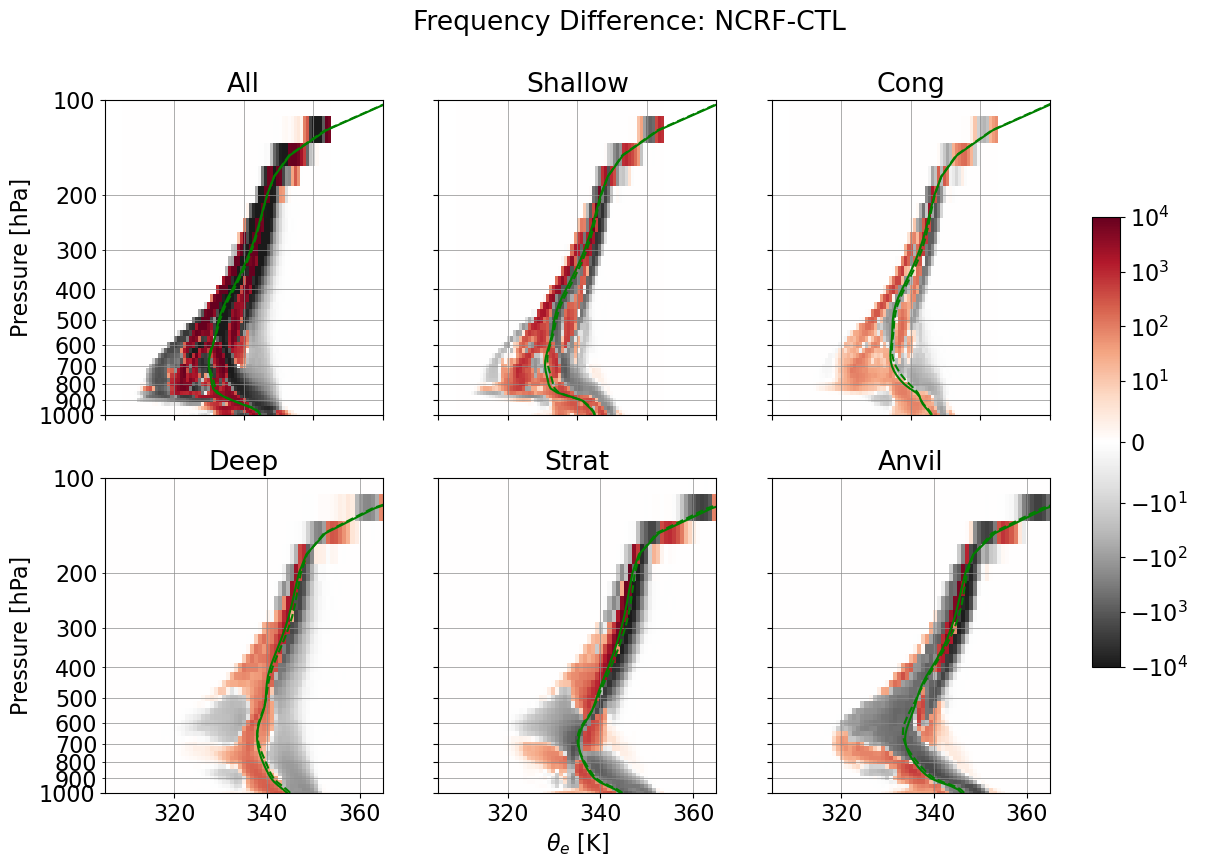

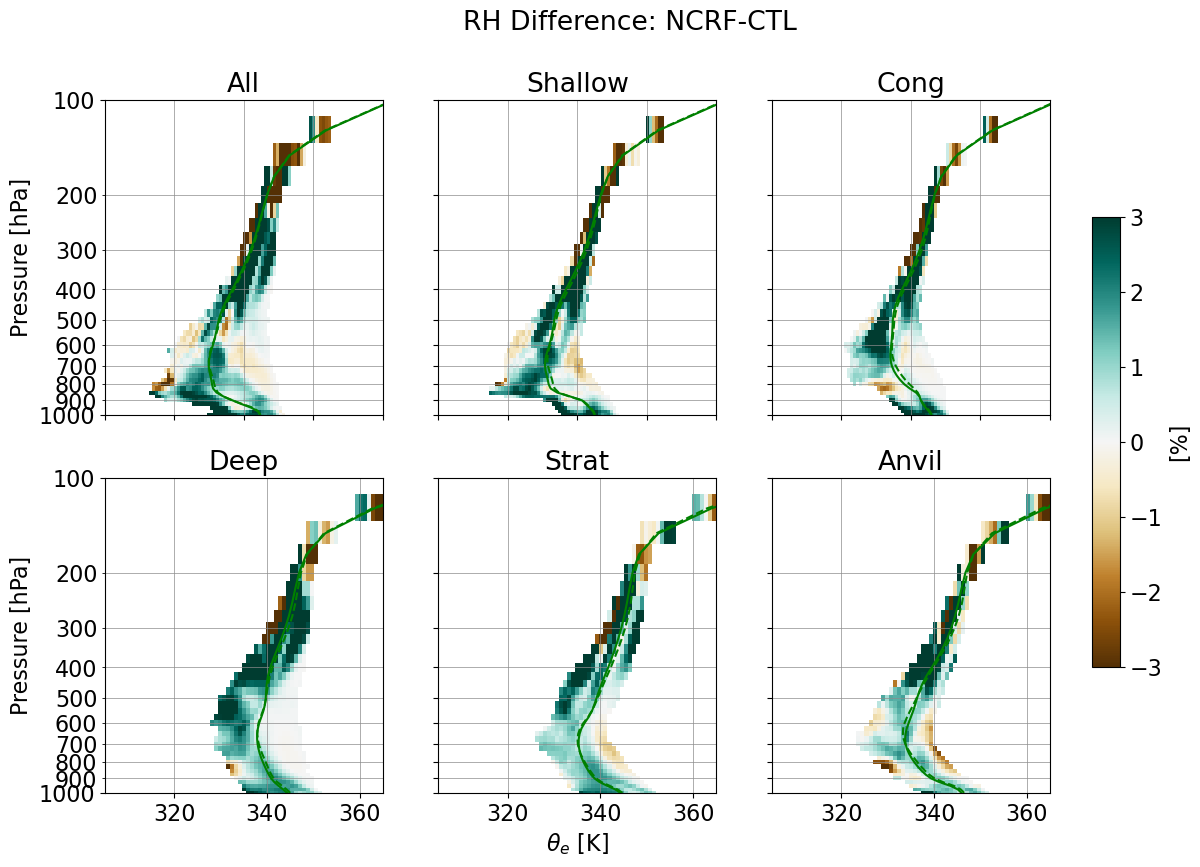

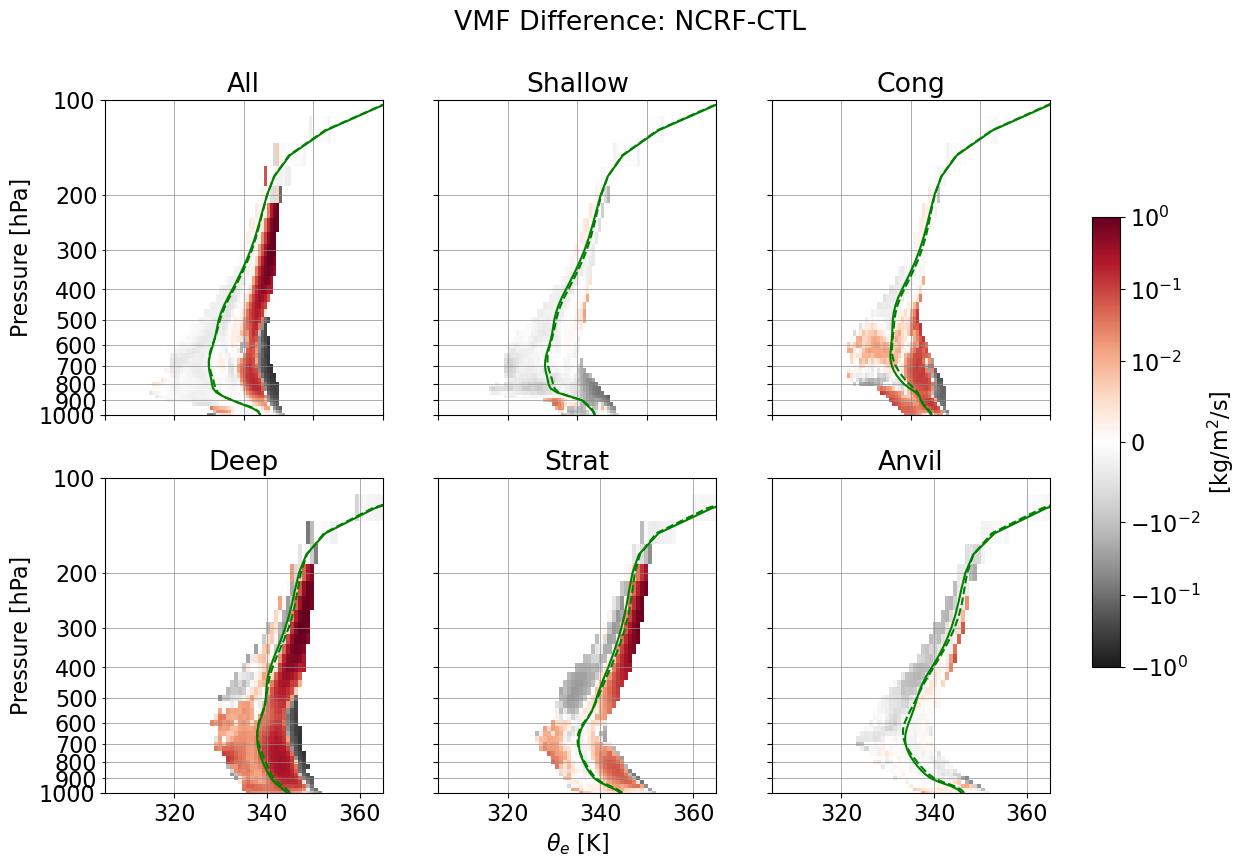

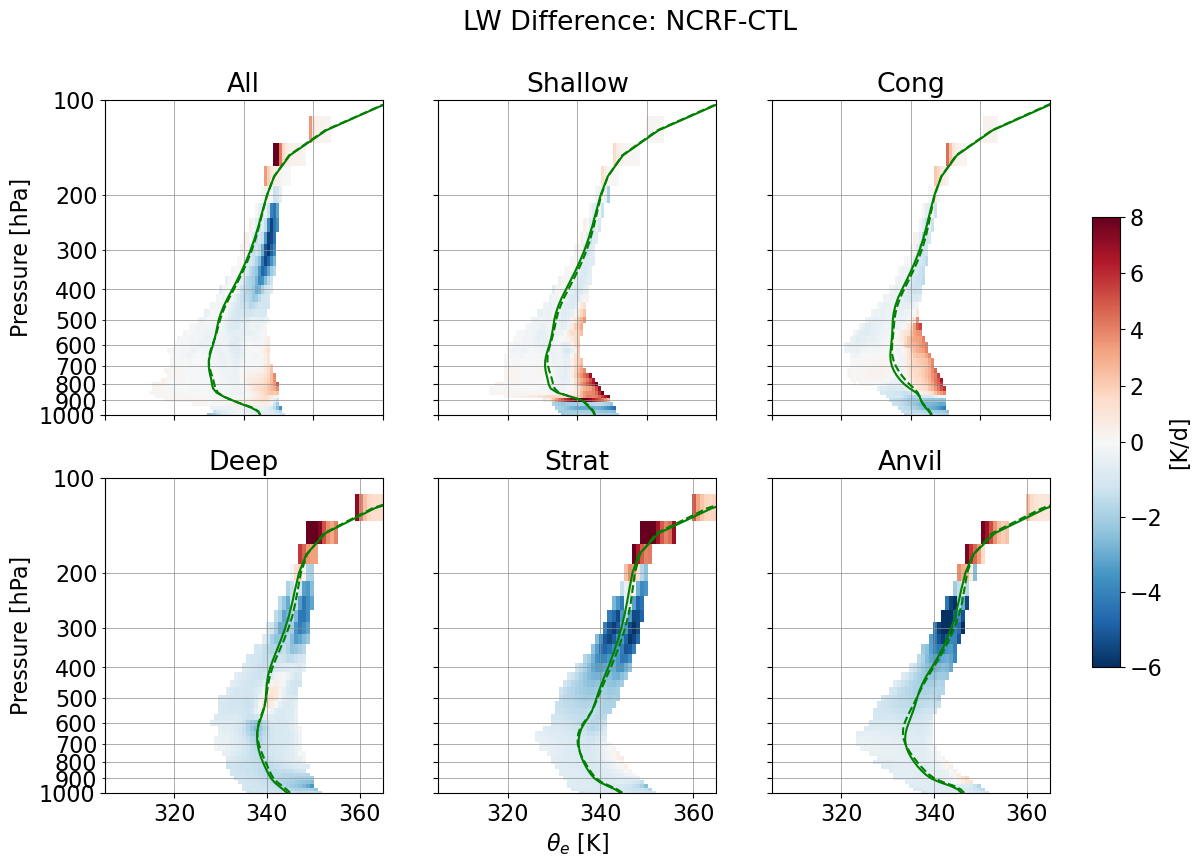

In [13]:
if not do_tests:

    run_ctl_plots(
        do_freq=True,
        do_freqnorm=True,
        do_relhum=True,
        do_vmf=True,
        do_lwcrf=True,
        do_swcrf=True,
        do_swrad=True,
        do_totrad=True,
        )

elif do_tests:

    run_testdiff_plots(
        do_freq=True,
        do_relhum=True,
        do_vmf=True,
        do_lwcrf=True,
        )